In [1]:
import torch
import matplotlib.pyplot as plt

import robustness_model

In [2]:
def gen_datapoints(original_dim, mean1, mean2, std1, std2):
    
    X1 = torch.empty(10, original_dim).normal_(mean=mean1,std=std1)
    X2 = torch.empty(10, original_dim).normal_(mean=mean2,std=std2)

    X = torch.concatenate((X1, X2), dim=0)
    y = torch.tensor([0 for _ in range(len(X1))] + [1 for _ in range(len(X2))])

    return X, y


def get_eps(model, q, L):
    phi_diff = model.class_hvs1 - model.class_hvs2
    phi_q = model.encoder(q.reshape(1, -1))
    r_q = model.encoder.inner(phi_diff.reshape(1, -1), phi_q)[0, 0]
    return torch.abs(r_q) / L


def get_boundary_locs(qs, sims):
    boundary_locs = []
    for i in range(len(qs) - 1):
        if(sims[i] * sims[i+1] <= 0):
            boundary_locs.append(qs[i])
    return torch.tensor(boundary_locs)


def plot_1d_epsilon(model, X, y, title=''):

    X1, X2 = X[y == 0], X[y == 1]

    vmin, vmax = X.min() - 10, X.max() + 10
    
    qs = torch.linspace(vmin, vmax, 1000).reshape(-1, 1)
    qs_enc = model.encoder(qs)
    sims = torch.tensor([model.encoder.inner(phi_q.reshape(1, -1), (model.class_hvs1 - model.class_hvs2).reshape(1, -1)) for phi_q in qs_enc])

    boundary_locs = get_boundary_locs(qs, sims)

    ds = [] # Actual
    es1 = [] # Method 1
    es2_r2 = [] # Method 2 (r=2)
    es2_r5 = [] # Method 2 (r=5)
    es3 = [] # Method 3

    for i in range(len(qs)):
        q = qs[i]
        sim = sims[i]
        d = torch.min(torch.abs(boundary_locs - q))

        L1 = model.get_linear_approximation(q)
        L2_r2 = model.get_conservative_lipschitz_constant(q)
        L2_r5 = model.get_conservative_lipschitz_constant(q, r=5)
        L3 = model.get_lipschitz_constant()

        e1 = get_eps(model, q, L1)
        e2_r2 = get_eps(model, q, L2_r2)
        e2_r5 = get_eps(model, q, L2_r5)
        e3 = get_eps(model, q, L3)

        ds.append(d)
        es1.append(e1)
        es2_r2.append(e2_r2)
        es2_r5.append(e2_r5)
        es3.append(e3)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 5))

    axes[0].fill_between(qs.reshape(-1), 0, 1, where=sims.reshape(-1) >= 0,
                    color='blue', alpha=0.3, transform=axes[0].get_xaxis_transform())
    axes[0].fill_between(qs.reshape(-1), 0, 1, where=sims.reshape(-1) < 0,
                    color='red', alpha=0.3, transform=axes[0].get_xaxis_transform())
    axes[0].plot(qs, sims, label="Similarity")
    axes[0].scatter(X1, torch.zeros(len(X1)), color='blue')
    axes[0].scatter(X2, torch.zeros(len(X2)), color='red')
    axes[0].set_xlabel("$x$")
    axes[0].legend()

    axes[1].plot(qs, ds, label="Actual")
    axes[1].plot(qs, es1, label="Method 1")
    axes[1].plot(qs, es2_r2, label="Method 2 (r=2)")
    axes[1].plot(qs, es2_r5, label="Method 2 (r=5)")
    axes[1].plot(qs, es3, label="Method 3")
    axes[1].scatter(X1, torch.zeros(len(X1)), color='blue')
    axes[1].scatter(X2, torch.zeros(len(X2)), color='red')
    axes[1].set_xlabel("$x$")
    axes[1].set_ylabel("$\epsilon$")
    axes[1].legend()
    
    axes[2].plot(qs, ds, label="Actual")
    axes[2].plot(qs, es1, label="Method 1")
    axes[2].plot(qs, es2_r2, label="Method 2 (r=2)")
    axes[2].plot(qs, es2_r5, label="Method 2 (r=5)")
    axes[2].plot(qs, es3, label="Method 3")
    axes[2].scatter(X1, torch.zeros(len(X1)), color='blue')
    axes[2].scatter(X2, torch.zeros(len(X2)), color='red')
    axes[2].set_xlabel("$x$")
    axes[2].set_ylabel("$\epsilon$")
    axes[2].set_ylim([-0.1, max(ds) + 0.1])
    axes[2].legend()

    fig.suptitle(title)

    fig.show()

In [3]:
def run_1d_test(original_dim, dim, mean1, mean2, std1, std2):
    
    X, y = gen_datapoints(original_dim, mean1, mean2, std1, std2)

    encoder = robustness_model.FHRREncoder(original_dim, dim)
    model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
    model.bundling(X, y)
    model.class_hvs1.shape, model.class_hvs2.shape

    print('Method1', model.get_linear_approximation(X[0]))
    print('Method1 (autograd)', model.get_linear_approximation_autograd(X[0]))
    print('Method2', model.get_conservative_lipschitz_constant(X[0]))
    print('Method3', model.get_lipschitz_constant())
    print('Method3 (autograd)', model.get_lipschitz_constant_autograd())

    plot_1d_epsilon(model, X, y, 
                    title=f'dim={dim}, class1$\in N({mean1}, {std1}^2)$, class2$\in N({mean2}, {std2}^2)$')

In [4]:
original_dim = 1
dim = 4000

Method1 tensor(4780.5278)
Method1 (autograd) tensor(4780.5278)
Method2 tensor(5266.8560)
Method3 tensor(700.8096)
Method3 (autograd) tensor(700.8096)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


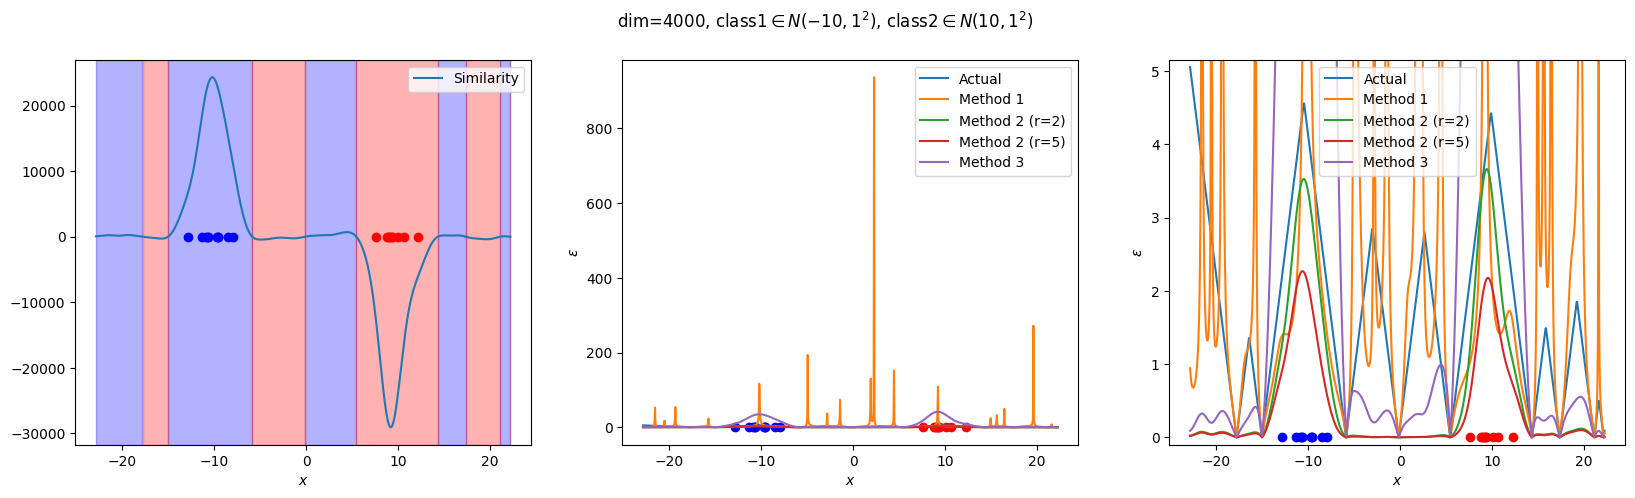

In [5]:
run_1d_test(original_dim, dim, -10, 10, 1, 1)

Method1 tensor(14620.3867)
Method1 (autograd) tensor(14620.4043)
Method2 tensor(43966.2969)
Method3 tensor(15847.4336)
Method3 (autograd) tensor(15847.4336)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


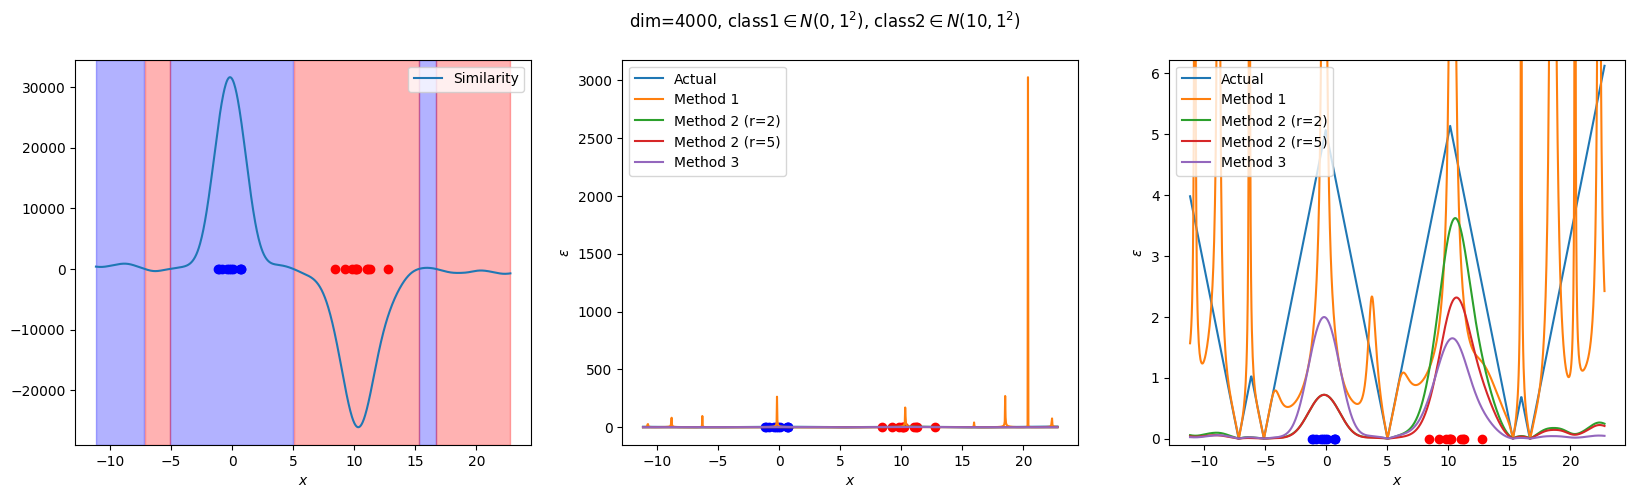

In [6]:
run_1d_test(original_dim, dim, 0, 10, 1, 1)

Method1 tensor(9676.2363)
Method1 (autograd) tensor(9676.2383)
Method2 tensor(43400.5547)
Method3 tensor(17212.5371)
Method3 (autograd) tensor(17212.5371)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


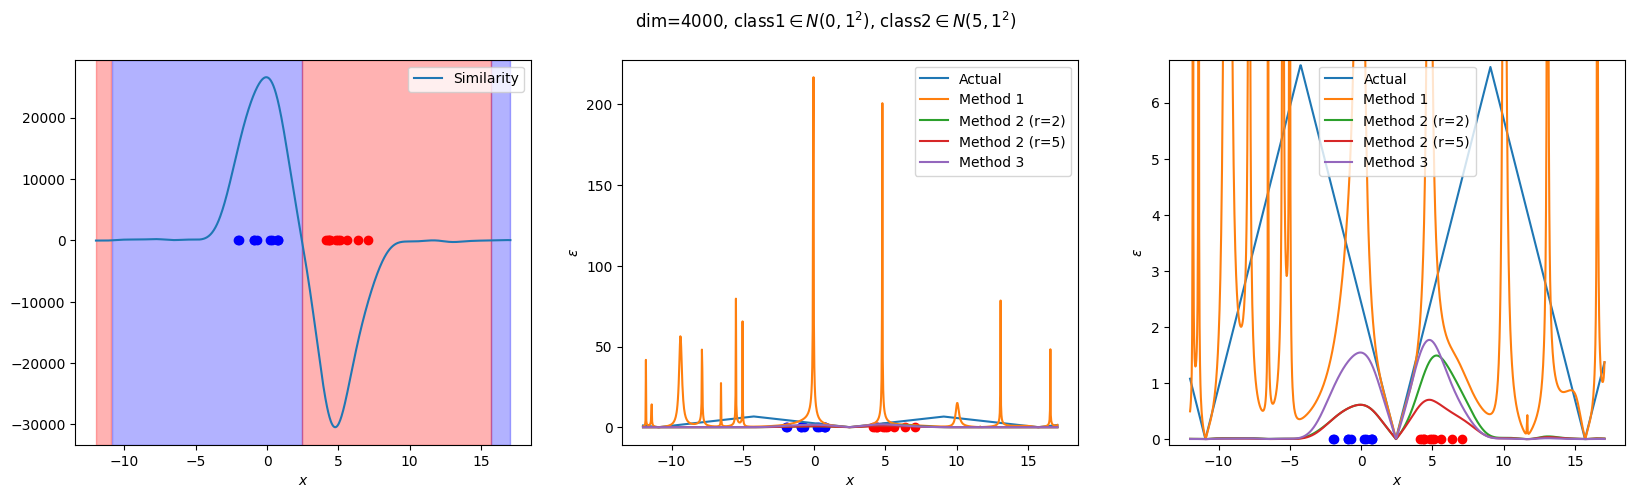

In [7]:
run_1d_test(original_dim, dim, 0, 5, 1, 1)

Method1 tensor(11246.8359)
Method1 (autograd) tensor(11246.8467)
Method2 tensor(30435.5938)
Method3 tensor(24659.5391)
Method3 (autograd) tensor(24659.5391)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


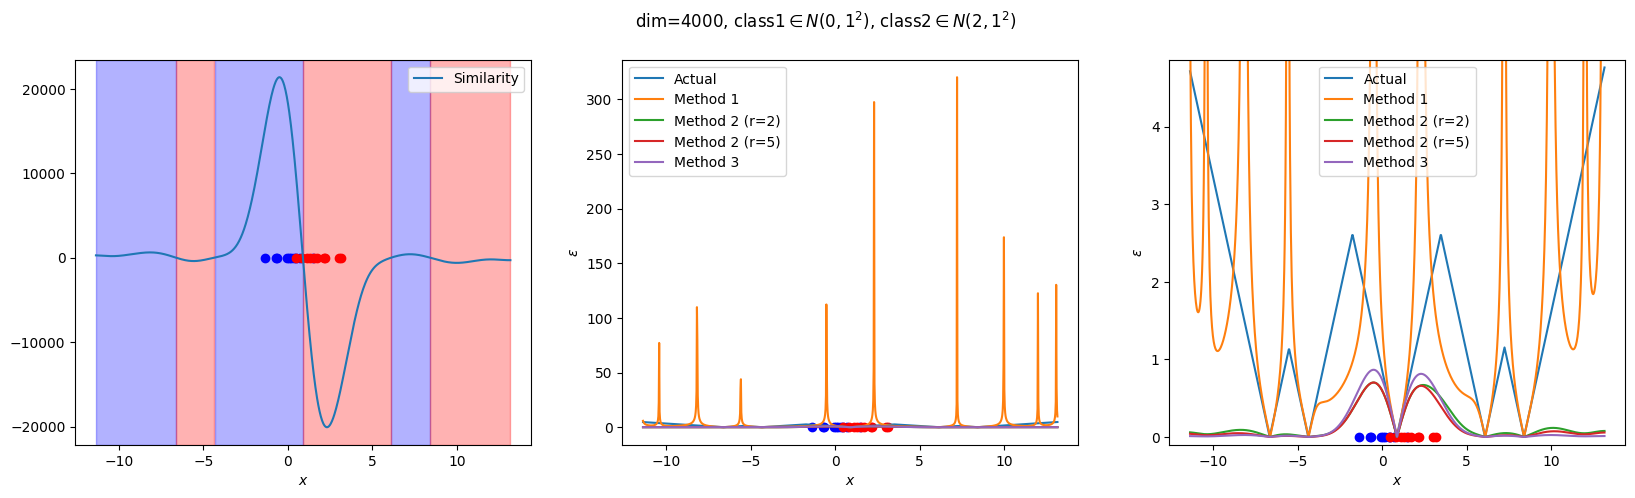

In [8]:
run_1d_test(original_dim, dim, 0, 2, 1, 1)

Method1 tensor(4115.7642)
Method1 (autograd) tensor(4115.7583)
Method2 tensor(4036.1768)
Method3 tensor(3606.8914)
Method3 (autograd) tensor(3606.8914)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


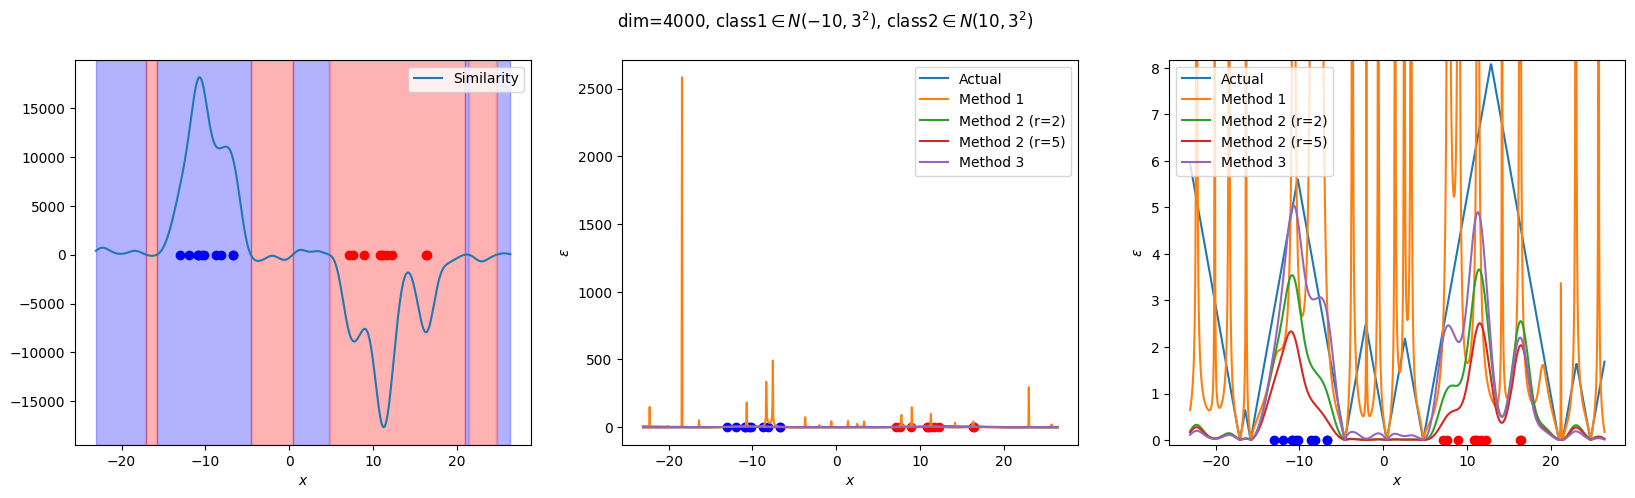

In [9]:
run_1d_test(original_dim, dim, -10, 10, 3, 3)

Method1 tensor(2631.2559)
Method1 (autograd) tensor(2631.2598)
Method2 tensor(18136.9531)
Method3 tensor(7442.8569)
Method3 (autograd) tensor(7442.8569)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


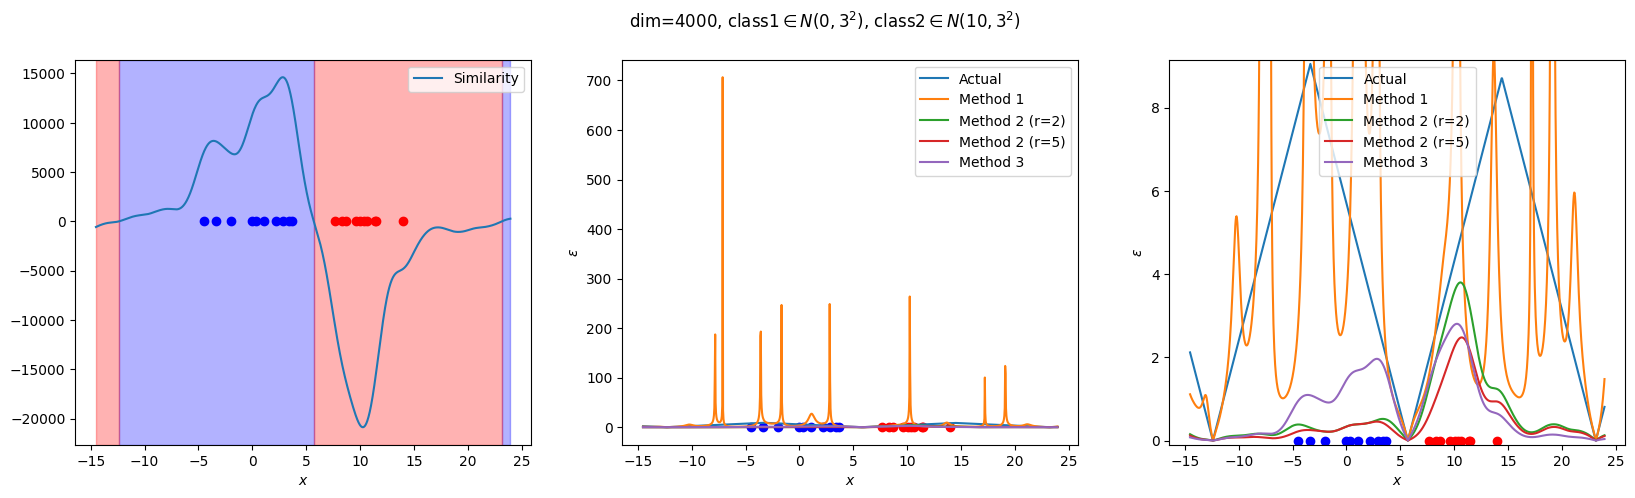

In [10]:
run_1d_test(original_dim, dim, 0, 10, 3, 3)

Method1 tensor(677.5893)
Method1 (autograd) tensor(677.5893)
Method2 tensor(20568.2656)
Method3 tensor(6500.8188)
Method3 (autograd) tensor(6500.8188)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


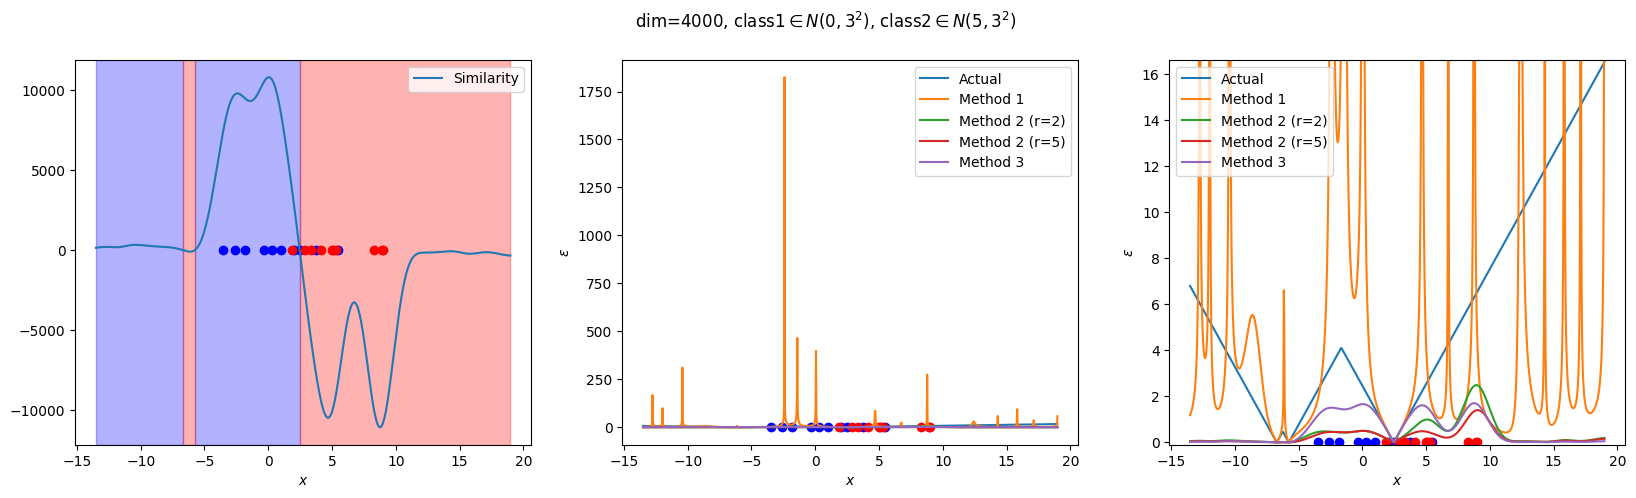

In [11]:
run_1d_test(original_dim, dim, 0, 5, 3, 3)

Method1 tensor(11415.4775)
Method1 (autograd) tensor(11415.4756)
Method2 tensor(18245.1641)
Method3 tensor(12318.8018)
Method3 (autograd) tensor(12318.8018)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55456/2143764051.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


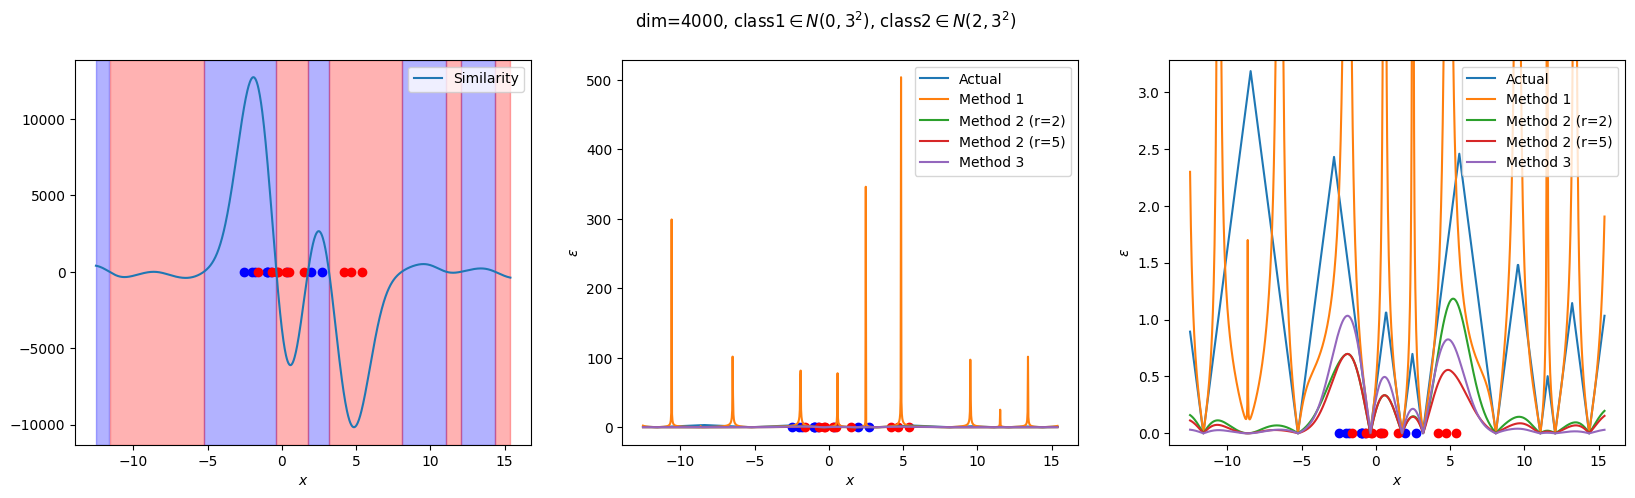

In [12]:
run_1d_test(original_dim, dim, 0, 2, 3, 3)